In [108]:
import glob
import pandas as pd
import json

projects = ["djanjo", "flask", "pytorch", "pandas"]
dfs=[]

for project in projects:
    filenames = glob.glob(f"../output/pytlint/{project}/*.json")
    for filename in filenames:
        with open(filename) as json_data:
            data = json.load(json_data)
            df = pd.json_normalize(data)
            df['project'] = project
            dfs.append(df)




In [109]:
df_py = pd.concat(dfs, ignore_index=True)

df_py.head(5)

,type,module,obj,line,column,endLine,endColumn,path,symbol,message,message-id,project
0,warning,flask.cli,FlaskGroup.list_commands,605,15,605,24,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
1,warning,flask.cli,run_command,898,11,898,20,projects/py/flask/src/flask/cli.py,broad-except,Catching too general exception Exception,W0703,flask
2,warning,test_reqctx,test_teardown_with_previous_exception,39,11,39,20,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
3,warning,test_reqctx,test_teardown_with_handled_exception,58,15,58,24,projects/py/flask/tests/test_reqctx.py,broad-except,Catching too general exception Exception,W0703,flask
4,warning,test_appctx,test_app_tearing_down_with_previous_exception,66,11,66,20,projects/py/flask/tests/test_appctx.py,broad-except,Catching too general exception Exception,W0703,flask


In [110]:
df_py.groupby(['project','message-id'])['message-id'].count()

project  message-id
flask    W0703           9
pandas   W0703          24
         W0706           2
         W0707          23
pytorch  E0702           5
         E0704           2
         W0702           4
         W0703         253
         W0706           6
         W0707           9
         W0715          11
Name: message-id, dtype: int64

In [111]:
import psycopg2

conn = psycopg2.connect("host={} user={} dbname=exception_miner password={} port={}".format("127.0.0.1", "exception_miner", "exception_miner", "5432"))
conn.set_session(autocommit=True)
cur = conn.cursor()

cur.execute("""CREATE TABLE IF NOT EXISTS exceptions_pylint (type VARCHAR(255), module VARCHAR(255), obj VARCHAR(255), beginLine INT, beginColumn INT,	endLine INT, endColumn INT, path VARCHAR(255), symbol VARCHAR(255), message VARCHAR(255), message_id VARCHAR(255), project VARCHAR(255))""")

cur.execute("""DELETE FROM exceptions_pylint;""")

for i, row in df_py.iterrows():
    #print(row)
    cur.execute(("""INSERT INTO exceptions_pylint (type, module, obj, beginLine, beginColumn, endLine, endColumn, path, symbol, message, message_id, project)
                            VALUES (%s, %s, %s, %s, %s, %s,%s, %s, %s, %s, %s, %s  );"""), list(row))

OperationalError: connection to server at "127.0.0.1", port 5432 failed: Connection refused
	Is the server running on that host and accepting TCP/IP connections?


Python Parser

In [176]:
import glob
import pandas as pd
import json

# projects = ["django", "flask", "pytorch", "pandas"]
projects = ["flask"]
dfs=[]

for project in projects:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(f"../output/parser/{project}_stats.csv")
    df['project'] = project
    dfs.append(df)


In [177]:
df = pd.concat(dfs, ignore_index=True)
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,test_add,"def test_add(client, a, b, result):\n respo...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1,/home/r4ph/desenv/exception-miner/projects/py/...,check,"def check(sender, template, context):\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
2,/home/r4ph/desenv/exception-miner/projects/py/...,test_index,"def test_index(app, client, path, template_nam...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
3,/home/r4ph/desenv/exception-miner/projects/py/...,client,def client(app):\n return app.test_client(),0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
4,/home/r4ph/desenv/exception-miner/projects/py/...,fixture_app,def fixture_app():\n app.testing = True\n ...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask


In [178]:
df[df['str_uncaught_exceptions'].isnull() == False].shape

(5, 18)

In [179]:
df[df['n_try_except'] > 1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
356,/home/r4ph/desenv/exception-miner/projects/py/...,test_build_error_handler,def test_build_error_handler(app):\n # Test...,2,0,0,0,1,0,0,0,0,0,BuildError RuntimeError,RuntimeError,"error = err pytest.raises(BuildError, app.hand...",NaN,flask
435,/home/r4ph/desenv/exception-miner/projects/py/...,test_teardown_request_handler_error,"def test_teardown_request_handler_error(app, c...",2,2,0,2,2,0,0,0,0,0,Exception Exception,TypeError TypeError,pass pass,NaN,flask
1173,/home/r4ph/desenv/exception-miner/projects/py/...,wsgi_app,"def wsgi_app(self, environ: dict, start_respon...",2,0,1,1,1,0,1,0,0,1,Exception,NaN,error = e\n response = self.han...,NaN,flask
1308,/home/r4ph/desenv/exception-miner/projects/py/...,convert,"def convert(self, value, param, ctx):\n ...",3,0,0,0,3,0,1,0,0,1,ImportError click BadParameter ImportError Imp...,NaN,raise click.BadParameter(\n 'Us...,NaN,flask
1315,/home/r4ph/desenv/exception-miner/projects/py/...,list_commands,"def list_commands(self, ctx):\n self._l...",2,0,0,1,0,0,0,0,0,0,NoAppException Exception,NaN,"click.secho(f""Error: {e.format_message()}\n"", ...",NaN,flask
1332,/home/r4ph/desenv/exception-miner/projects/py/...,find_app_by_string,"def find_app_by_string(module, app_name):\n ...",4,0,0,0,8,0,0,0,0,0,SyntaxError ValueError AttributeError TypeError,NoAppException NoAppException NoAppException N...,"raise NoAppException(\n f""Failed to...",NaN,flask


In [180]:
df.shape

(1412, 18)

In [181]:
#TODO:
#Analisar Duplicados
df[df.duplicated()]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
157,/home/r4ph/desenv/exception-miner/projects/py/...,hello_command,"def hello_command():\n click.echo(""Hell...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
162,/home/r4ph/desenv/exception-miner/projects/py/...,view,def view(company_id):\n return company_id,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
187,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
193,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n flask.g.user_agent = fla...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
195,/home/r4ph/desenv/exception-miner/projects/py/...,index,def index():\n return flask.request.url,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1008,/home/r4ph/desenv/exception-miner/projects/py/...,index,"def index():\n return f""Hello {flask.re...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1015,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1017,/home/r4ph/desenv/exception-miner/projects/py/...,end_of_request,def end_of_request(exception):\n buffer...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask
1088,/home/r4ph/desenv/exception-miner/projects/py/...,to_json,"def to_json(self, value: t.Any) -> t.Any:\n ...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,flask


In [182]:
df = df.drop_duplicates().shape

Analyzing the Control Flow and Code

In [183]:
import glob
import pandas as pd
import json

projects = ["django", "flask", "pytorch", "pandas"]
dfs=[]
filenames = glob.glob(f"../output/parser/*.csv")

for filename in filenames:
    #filenames = glob.glob(f"../output/parser/*.csv")
    #print(filename)
    df = pd.read_csv(filename)
    project = filename.split("/")[-1].split("_")[0]
    df['project'] = project
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

In [184]:
df.project.unique()

array(['fastapi', 'rich', 'sherlock', 'youtube-dl', 'tensorflow-models',
       'scrapy', 'scikit-learn', 'certbot', 'keras', 'requests', 'flask',
       'manim', 'black', 'openpilot'], dtype=object)

In [185]:
df.shape

(68124, 18)

In [186]:
df.head(5)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
0,/home/r4ph/desenv/exception-miner/projects/py/...,get_sections,"def get_sections(nav: list) -> Dict[Tuple[str,...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,fastapi
1,/home/r4ph/desenv/exception-miner/projects/py/...,get_file_to_nav_map,def get_file_to_nav_map(nav: list) -> Dict[str...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,fastapi
2,/home/r4ph/desenv/exception-miner/projects/py/...,get_text_with_translate_missing,def get_text_with_translate_missing(text: str)...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,fastapi
3,/home/r4ph/desenv/exception-miner/projects/py/...,get_key_section,"def get_key_section(\n *, key_to_section: D...",0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,fastapi
4,/home/r4ph/desenv/exception-miner/projects/py/...,update_config,def update_config(lang: str):\n lang_path: ...,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,fastapi


In [187]:
df[df['str_except_identifiers'].notna()].head(10)

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
138,/home/r4ph/desenv/exception-miner/projects/py/...,custom_route_handler,async def custom_route_handler(request: Reques...,1,0,0,0,1,0,0,0,0,1,RequestValidationError,HTTPException,body = await request.body()\n d...,NaN,fastapi
139,/home/r4ph/desenv/exception-miner/projects/py/...,get_route_handler,def get_route_handler(self) -> Callable:\n ...,1,0,0,0,1,0,0,0,0,1,RequestValidationError,HTTPException,body = await request.body()\n d...,NaN,fastapi
431,/home/r4ph/desenv/exception-miner/projects/py/...,websocket_endpoint,async def websocket_endpoint(websocket: WebSoc...,1,0,0,0,0,0,0,0,0,0,WebSocketDisconnect,NaN,manager.disconnect(websocket)\n await m...,NaN,fastapi
438,/home/r4ph/desenv/exception-miner/projects/py/...,websocket_endpoint,async def websocket_endpoint(websocket: WebSoc...,1,0,0,0,0,0,0,0,0,0,WebSocketDisconnect,NaN,manager.disconnect(websocket)\n await m...,NaN,fastapi
635,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(token: Annotated[st...,1,0,0,0,3,0,0,0,0,0,JWTError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi
645,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(token: str = Depend...,1,0,0,0,3,0,0,0,0,0,JWTError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi
668,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(\n security_scop...,1,0,0,0,4,0,0,0,0,0,JWTError ValidationError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi
679,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(\n security_scop...,1,0,0,0,4,0,0,0,0,0,JWTError ValidationError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi
691,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(\n security_scop...,1,0,0,0,4,0,0,0,0,0,JWTError ValidationError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi
701,/home/r4ph/desenv/exception-miner/projects/py/...,get_current_user,async def get_current_user(token: str = Depend...,1,0,0,0,3,0,0,0,0,0,JWTError,credentials_exception credentials_exception cr...,raise credentials_exception,NaN,fastapi


In [188]:
df.iloc[428,:].func_body

'async def websocket_endpoint(\n    websocket: WebSocket,\n    item_id: str,\n    q: Union[int, None] = None,\n    cookie_or_token: str = Depends(get_cookie_or_token),\n):\n    await websocket.accept()\n    while True:\n        data = await websocket.receive_text()\n        await websocket.send_text(\n            f"Session cookie or query token value is: {cookie_or_token}"\n        )\n        if q is not None:\n            await websocket.send_text(f"Query parameter q is: {q}")\n        await websocket.send_text(f"Message text was: {data}, for item ID: {item_id}")'

In [189]:
df.iloc[428,:].str_except_identifiers

nan

In [190]:
df[df['n_finally'] > 1]#.count()

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
5601,/home/r4ph/desenv/exception-miner/projects/py/...,win_uninstall_service,def win_uninstall_service(service_name):\n ...,0,0,2,0,2,0,0,0,0,0,NaN,OSError OSError,NaN,NaN,youtube-dl
28878,/home/r4ph/desenv/exception-miner/projects/py/...,test_dupefilter_path,def test_dupefilter_path(self):\n r1 = ...,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scrapy
36136,/home/r4ph/desenv/exception-miner/projects/py/...,test_gradient_descent_stops,def test_gradient_descent_stops():\n # Test...,0,0,3,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
36819,/home/r4ph/desenv/exception-miner/projects/py/...,_sparse_encode_precomputed,"def _sparse_encode_precomputed(\n X,\n d...",0,0,2,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,scikit-learn
44756,/home/r4ph/desenv/exception-miner/projects/py/...,release,"def release(self) -> None:\n """"""Remove,...",0,0,2,0,1,0,0,0,0,0,NaN,TypeError,NaN,NaN,certbot
45095,/home/r4ph/desenv/exception-miner/projects/py/...,makedirs,"def makedirs(file_path: str, mode: int = 0o777...",0,0,2,0,0,0,0,0,0,1,NaN,NaN,NaN,NaN,certbot
62798,/home/r4ph/desenv/exception-miner/projects/py/...,reformat_many,"def reformat_many(\n sources: Set[Path],\n ...",1,0,2,0,0,0,0,0,0,0,ImportError NotImplementedError OSError,NaN,executor = ThreadPoolExecutor(max_workers=1),NaN,black
68054,/home/r4ph/desenv/exception-miner/projects/py/...,transact,"def transact(self, dat):\n def _handle_time...",0,0,2,0,1,0,0,0,0,0,NaN,TimeoutError,NaN,NaN,openpilot


In [191]:
df.iloc[500, :].func_body

'async def create_files(\n    files: Annotated[List[bytes], File(description="Multiple files as bytes")],\n):\n    return {"file_sizes": [len(file) for file in files]}'

In [192]:
# from pandasql import sqldf

# q = """SELECT asd.project,
#        asd.n_functions,
#        asd.n_try_except,
#        ROUND((CAST(asd.n_try_except AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100                 as perc_trys_func,
#        asd.n_try_return,
#        ROUND((CAST(asd.n_try_return AS FLOAT) / CAST (asd.n_functions AS FLOAT)), 4) * 100  as perc_n_try_return,
#        asd.n_generic_except,
#        ROUND((CAST(asd.n_generic_except AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100            as perc_try_generic,
#        asd.n_try_pass,
#        ROUND((CAST(asd.n_try_pass AS FLOAT) / CAST(asd.n_try_except AS FLOAT)), 4) * 100                  as perc_try_pass,
#        asd.n_try_else,
#        ROUND((CAST(asd.n_try_else AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_n_try_else,
#        asd.n_raise,
#        ROUND((CAST(asd.n_raise AS FLOAT) / CAST(asd.n_functions AS FLOAT)), 4) * 100 as perc_raise,
#        asd.n_captures_try_except_raise,
#        ROUND((CAST(asd.n_captures_try_except_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100 as perc_try_except_raise,
#        asd.n_captures_broad_raise,
#        ROUND((CAST(asd.n_captures_broad_raise AS FLOAT) / CAST(asd.n_raise AS FLOAT)), 4) * 100      as perc_raise_broad,
#        asd.n_captures_misplaced_bare_raise,
#        ROUND((CAST(asd.n_captures_misplaced_bare_raise AS FLOAT) / CAST (asd.n_raise AS FLOAT)), 4) * 100  as perc_raise_mis_bare,
#        asd.n_finally,
#        ROUND((CAST(asd.n_finally AS FLOAT) / CAST (asd.n_try_except AS FLOAT)), 4) * 100  as perc_finally
# FROM (SELECT a.project,
#              COUNT(DISTINCT a.function)                n_functions,
#              SUM(a.n_try_except)                    as n_try_except,
#              SUM(a.n_generic_except)                as n_generic_except,
#              SUM(a.n_try_pass)                      as n_try_pass,
#              SUM(a.n_raise)                         as n_raise,
#              SUM(a.n_captures_try_except_raise)     as n_captures_try_except_raise,
#              SUM(a.n_captures_misplaced_bare_raise) as n_captures_misplaced_bare_raise,
#              SUM(a.n_captures_broad_raise)          as n_captures_broad_raise,
#              SUM(a.n_try_else)                      as n_try_else,
#              SUM(a.n_try_return)                    as n_try_return,
#              SUM(a.n_finally)                       as n_finally
#       FROM df a
#       GROUP BY a.project) asd;"""
# sqldf(q)



In [193]:
df[df['n_try_except'] >1]

,file,function,func_body,n_try_except,n_try_pass,n_finally,n_generic_except,n_raise,n_captures_broad_raise,n_captures_try_except_raise,n_captures_misplaced_bare_raise,n_try_else,n_try_return,str_except_identifiers,str_raise_identifiers,str_except_block,str_uncaught_exceptions,project
1019,/home/r4ph/desenv/exception-miner/projects/py/...,create_item,async def create_item(request: Request):\n ...,2,0,0,0,2,0,0,0,0,0,yaml YAMLError ValidationError,HTTPException HTTPException,"raise HTTPException(status_code=422, detail=""I...",NaN,fastapi
1132,/home/r4ph/desenv/exception-miner/projects/py/...,check_file_field,def check_file_field(field: ModelField) -> Non...,2,0,0,0,2,0,0,0,0,0,ImportError ImportError,RuntimeError RuntimeError,logger.error(multipart_incorrect_install_error...,NaN,fastapi
1213,/home/r4ph/desenv/exception-miner/projects/py/...,app,async def app(request: Request) -> Response:\n...,3,0,0,1,4,0,1,0,0,0,json JSONDecodeError HTTPException Exception,RequestValidationError HTTPException RequestVa...,raise RequestValidationError(\n ...,NaN,fastapi
1214,/home/r4ph/desenv/exception-miner/projects/py/...,get_request_handler,def get_request_handler(\n dependant: Depen...,3,0,0,1,4,0,1,0,0,0,json JSONDecodeError HTTPException Exception,RequestValidationError HTTPException RequestVa...,raise RequestValidationError(\n ...,NaN,fastapi
1283,/home/r4ph/desenv/exception-miner/projects/py/...,jsonable_encoder,"def jsonable_encoder(\n obj: Any,\n incl...",2,0,0,2,1,0,0,0,0,0,Exception Exception Exception,ValueError,errors: List[Exception] = []\n errors.a...,NaN,fastapi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67426,/home/r4ph/desenv/exception-miner/projects/py/...,reconnect,def reconnect(self):\n if self._handle_open...,2,2,0,2,1,1,0,0,0,0,Exception Exception Exception,Exception,"logging.debug(""reconnecting is taking %d secon...",NaN,openpilot
67430,/home/r4ph/desenv/exception-miner/projects/py/...,usb_list,def usb_list():\n ret = []\n try:\n ...,2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,"continue logging.exception(""exception while li...",NaN,openpilot
67432,/home/r4ph/desenv/exception-miner/projects/py/...,usb_connect,"def usb_connect(serial, claim=True, wait=False...",2,0,0,2,0,0,0,0,0,0,Exception Exception,NaN,"continue logging.exception(""USB connect error"")",NaN,openpilot
67470,/home/r4ph/desenv/exception-miner/projects/py/...,usb_list,def usb_list() -> List[str]:\n dfu_serials ...,2,2,0,2,0,0,0,0,0,0,Exception Exception,NaN,pass pass,NaN,openpilot


In [194]:
df.str_except_block

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
68119    NaN
68120    NaN
68121    NaN
68122    NaN
68123    NaN
Name: str_except_block, Length: 68124, dtype: object

In [195]:
df.str_except_block.str.split(" ").explode().value_counts().reset_index().head(50)
#df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()
#df_raise_types = df_raise_types[1:]
#df_raise_types.head(20)

,index,str_except_block
0,,55862
1,raise,844
2,=,782
3,if,454
4,return,420
5,to,328
6,pass,317
7,"""\n",298
8,not,278
9,the,221


In [196]:
df.str_except_identifiers.unique()

array([nan, 'RequestValidationError', 'WebSocketDisconnect', 'JWTError',
       'JWTError ValidationError', 'yaml YAMLError ValidationError',
       'AttributeError', 'ImportError ImportError', 'Exception',
       'ValueError UnicodeDecodeError binascii Error',
       'json JSONDecodeError HTTPException Exception', 'RuntimeError',
       'Exception Exception Exception', 'SyncDependencyError',
       'AsyncDependencyError', 'HTTPException',
       'ValueError TypeError OSError TypeError', 'StopIteration',
       'TypeError', 'KeyError', 'ColorParseError ColorParseError',
       'errors StyleSyntaxError', 'ImportError',
       'UnicodeEncodeError UnicodeEncodeError',
       'AttributeError ValueError OSError AttributeError ValueError OSError',
       'ValueError', 'NameError',
       'KeyError IndexError SyntaxError Exception', 'ClassNotFound',
       'ClassNotFound ClassNotFound', 'KeyError KeyError KeyError',
       'ModuleNotFoundError', 'Exception Exception Exception Exception',
    

RQ1. How common and what are the main characteristics of exception handling practices in Python open-source projects?

In [197]:
cols = ['n_try_except', 'n_raise', 'n_finally', 'n_try_else']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [198]:
df_rq1 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] })
df_rq1 = df_rq1.max().to_frame().T

#df_rq1 = df.groupby('project').agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_finally_uni': ['sum'], 'n_try_else_uni': ['sum'] }).reset_index()
#df_rq1.columns = list(map(''.join, df_rq1.columns.values))


In [199]:
cols = ['n_finally_uni', 'n_try_else_uni']

df_rq1['perc_n_try_except_uni'] = (df_rq1['n_try_except_uni']/ df_rq1['function']) * 100
df_rq1['perc_n_raise_uni'] = (df_rq1['n_raise_uni']/ df_rq1['function']) * 100

for col in cols:
     df_rq1['perc_'+col]= (df_rq1[col]/ df_rq1['n_try_except_uni']) * 100

df_rq1

,function,n_try_except_uni,n_raise_uni,n_finally_uni,n_try_else_uni,perc_n_try_except_uni,perc_n_raise_uni,perc_n_finally_uni,perc_n_try_else_uni
0,68121.0,1804.0,5613.0,318.0,104.0,2.648229,8.23975,17.627494,5.764967


In [200]:
#df_rq1.loc[:, ["perc_n_try_except_unisum", "perc_n_raise_unisum", "perc_n_try_else_unisum", "perc_n_finally_unisum"]]

In [201]:
#df_total = df_rq1.agg({'perc_n_try_except_unisum': ['median', 'mean'], 'perc_n_raise_unisum': ['median', 'mean'], 'perc_n_try_else_unisum': ['median', 'mean'], 'perc_n_finally_unisum': ['median', 'mean']})
#df_total

In [202]:
df_total = df_rq1.loc[:, ["perc_n_try_except_uni", "perc_n_raise_uni", "perc_n_try_else_uni", "perc_n_finally_uni"]]

In [203]:
df_total.columns = ['Exception Handling', 'Raise', 'Try & Else', 'Finally']
df_total

,Exception Handling,Raise,Try & Else,Finally
0,2.648229,8.23975,5.764967,17.627494


In [204]:
df_total = df_total.T[0:].reset_index()
df_total

,index,0
0,Exception Handling,2.648229
1,Raise,8.239750
2,Try & Else,5.764967
3,Finally,17.627494


In [205]:
#rename columns:
df_total.columns = ['Exception Handling', 'Percentage']
df_total['Percentage'] = df_total['Percentage'].round(2)

df_total

,Exception Handling,Percentage
0,Exception Handling,2.65
1,Raise,8.24
2,Try & Else,5.76
3,Finally,17.63


Boxplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


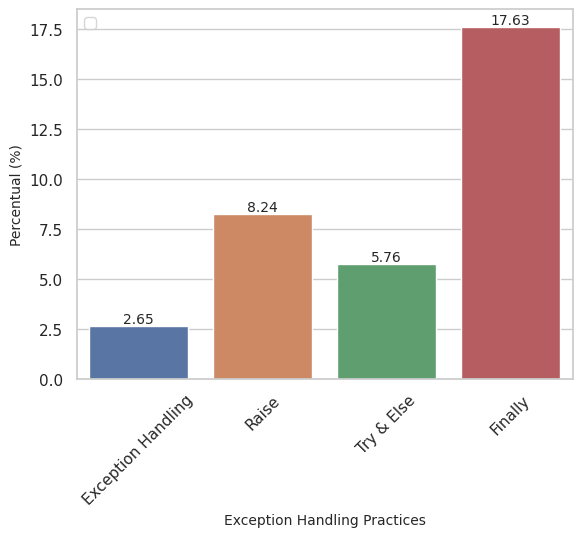

In [234]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total, x="Exception Handling", y="Percentage")
plt.ylabel("Percentual (%)", fontsize= 10)
plt.xlabel("Exception Handling Practices", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)



In [207]:
df_except_types = df.str_except_identifiers.str.split(" ").explode().value_counts().reset_index()

In [208]:
df_except_types

,index,str_except_identifiers
0,Exception,365
1,ValueError,246
2,OSError,156
3,errors,147
4,TypeError,145
...,...,...
307,OverlappingMatchFound,1
308,ReadError,1
309,CertificateError,1
310,VerificationError,1


In [209]:
#df_except_types = df_except_types[1:]

In [210]:
df_except_types.head(20)

,index,str_except_identifiers
0,Exception,365
1,ValueError,246
2,OSError,156
3,errors,147
4,TypeError,145
5,ImportError,125
6,AttributeError,118
7,KeyError,117
8,ExtractorError,101
9,IOError,85


In [211]:
def get_capitalized_elements(list):
    for element in list:
        if element[0].isupper():
            return element

In [212]:
#TODO: get a list of built-in exceptions and flag them
df_except_types['str_uniq_identifiers'] = df_except_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_except_types = df_except_types[df_except_types['str_uniq_identifiers'].notna()].head(20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


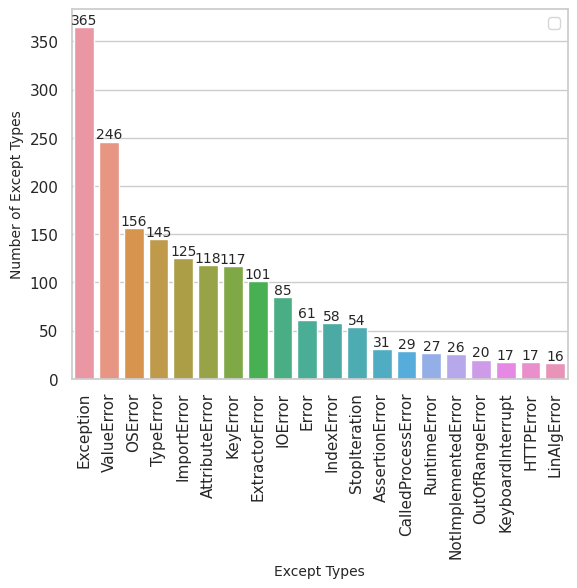

In [213]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_except_types.head(20), x="str_uniq_identifiers", y="str_except_identifiers")
plt.ylabel("Number of Except Types", fontsize= 10)
plt.xlabel("Except Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)


In [214]:
df_raise_types = df.str_raise_identifiers.str.split(" ").explode().value_counts().reset_index()
df_raise_types = df_raise_types[1:]
df_raise_types.head(20)

,index,str_raise_identifiers
1,ExtractorError,490
2,Exception,459
3,NotImplementedError,438
4,TypeError,333
5,RuntimeError,252
6,HTTPException,139
7,AttributeError,87
8,AssertionError,87
9,ParseException,54
10,KeyError,49


In [215]:
df_raise_types['str_uniq_identifiers'] = df_raise_types['index'].apply(lambda x: get_capitalized_elements(x.split(".")))

df_raise_types = df_raise_types[df_raise_types['str_uniq_identifiers'].notna()].head(20)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


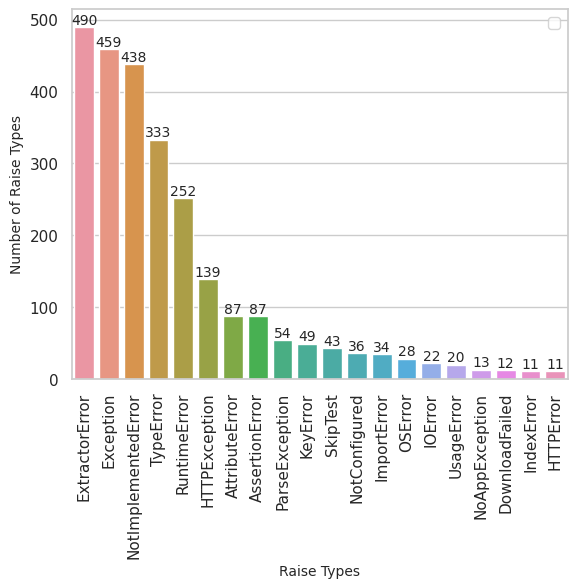

In [216]:
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_raise_types.head(20), x="index", y="str_raise_identifiers")
plt.ylabel("Number of Raise Types", fontsize= 10)
plt.xlabel("Raise Types", fontsize= 10)
plt.tick_params(axis='x', rotation=90)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

RQ2. 

In [217]:
df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.values

#df.str_uncaught_exceptions.str.split("[.][.][.]").values

array(['...src.flask.helpers.stream_with_context:RuntimeError',
       '...src.flask.cli.locate_app:NoAppException ...src.flask.cli.locate_app:NoAppException',
       '...src.flask.cli.find_best_app:NoAppException ...src.flask.cli.find_app_by_string:NoAppException',
       '...src.flask.scaffold._find_package_path:ValueError',
       '...src.flask.scaffold._matching_loader_thinks_module_is_package:AttributeError',
       '...src.black.get_future_imports:AssertionError',
       '...src.black.validate_cell:NothingChanged',
       '...src.black.format_ipynb_string:NothingChanged ...src.black.format_ipynb_string:NothingChanged',
       '...src.black.assert_equivalent:AssertionError ...src.black.assert_equivalent:AssertionError ...src.black.assert_equivalent:AssertionError ...src.black.assert_stable:AssertionError',
       '...src.black.format_file_in_place:ValueError',
       '...src.black.linegen.run_transformer:CannotTransform',
       '...src.black.linegen.standalone_comment_split:Canno

In [218]:
import numpy as np
#Couting uncaught exceptions:
#df[df.str_uncaught_exceptions.notna()].str_uncaught_exceptions.str.split("[.][.][.]").values[3]

df['n_uncaught_exceptions'] = df['str_uncaught_exceptions'].str.split("[.][.][.]").apply(lambda x: len(x)-1 if x is not np.nan else 0)

In [219]:
cols = ['n_try_pass', 'n_generic_except', 'n_captures_try_except_raise', 'n_captures_broad_raise']

for col in cols:
    df[col+'_uni'] = df[col].apply(lambda x: 1 if x >= 1 else x)

In [220]:
df_rq2 = df.agg({'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']})
df_rq2 = df_rq2.max().to_frame().T

In [221]:
df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions
0,68121.0,1804.0,285.0,346.0,5613.0,158.0,351.0,31.0


In [222]:
#Trys
df_rq2['perc_n_try_pass_uni'] = (df_rq2['n_try_pass_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_n_generic_except_uni'] = (df_rq2['n_generic_except_uni']/ df_rq2['n_try_except_uni']) * 100
df_rq2['perc_uncaught_exceptions'] = (df_rq2['n_uncaught_exceptions']/ df_rq2['n_try_except_uni']) * 100

#Raise
df_rq2['perc_n_captures_try_except_raise_uni'] = (df_rq2['n_captures_try_except_raise_uni']/ df_rq2['n_raise_uni']) * 100
df_rq2['perc_n_captures_broad_raise_uni'] = (df_rq2['n_captures_broad_raise_uni']/ df_rq2['n_raise_uni']) * 100

df_rq2

,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,68121.0,1804.0,285.0,346.0,5613.0,158.0,351.0,31.0,15.798226,19.179601,1.718404,2.814894,6.25334


In [223]:
df_total_rq2 = df_rq2.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,15.798226,19.179601,2.814894,6.25334,1.718404


In [224]:
df_total_rq2.columns = ['CWE-391', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2

,CWE-391,CWE-396,CWE-252,CWE-397,CWE-248
0,15.798226,19.179601,2.814894,6.25334,1.718404


In [225]:
df_total_rq2 = df_total_rq2.T[0:].reset_index()
df_total_rq2

,index,0
0,CWE-391,15.798226
1,CWE-396,19.179601
2,CWE-252,2.814894
3,CWE-397,6.253340
4,CWE-248,1.718404


In [226]:
#rename columns:
df_total_rq2.columns = ['Exception Handling', 'Percentage']
df_total_rq2['Percentage'] = df_total_rq2['Percentage'].round(2)

#order by percentage:
df_total_rq2 = df_total_rq2.sort_values(by=['Percentage'], ascending=False)
df_total_rq2

,Exception Handling,Percentage
1,CWE-396,19.18
0,CWE-391,15.80
3,CWE-397,6.25
2,CWE-252,2.81
4,CWE-248,1.72


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


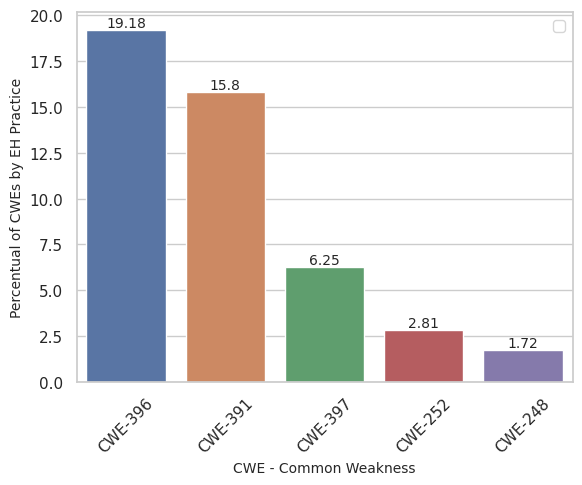

In [235]:
import seaborn as sns
sns.set_theme(style="whitegrid")

ax = sns.barplot(data=df_total_rq2, x="Exception Handling", y="Percentage")
plt.ylabel("Percentual of CWEs by EH Practice", fontsize= 10)
plt.xlabel("CWE - Common Weakness", fontsize= 10)
plt.tick_params(axis='x', rotation=45)
plt.legend(loc="best", ncol=3)
plt.title("", fontsize= 15)

for i in ax.containers:
    ax.bar_label(i, fontsize=10)

In [228]:
df_rq2_box = df[['project', 'function', 'n_try_except_uni', 'n_try_pass_uni', 'n_generic_except_uni', 'n_raise_uni', 'n_captures_try_except_raise_uni', 'n_captures_broad_raise_uni', 'n_uncaught_exceptions']]
df_rq2_box = df.groupby('project').agg( {'function': ['count'], 'n_try_except_uni': ['sum'], 'n_try_pass_uni': ['sum'], 'n_generic_except_uni': ['sum'], 'n_raise_uni': ['sum'], 'n_captures_try_except_raise_uni': ['sum'], 'n_captures_broad_raise_uni': ['sum'], 'n_uncaught_exceptions': ['sum']}).droplevel(1, axis=1).reset_index()

In [229]:
#Trys
df_rq2_box['perc_n_try_pass_uni'] = (df_rq2_box['n_try_pass_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_n_generic_except_uni'] = (df_rq2_box['n_generic_except_uni']/ df_rq2_box['n_try_except_uni']) * 100
df_rq2_box['perc_uncaught_exceptions'] = (df_rq2_box['n_uncaught_exceptions']/ df_rq2_box['n_try_except_uni']) * 100

#Raise
df_rq2_box['perc_n_captures_try_except_raise_uni'] = (df_rq2_box['n_captures_try_except_raise_uni']/ df_rq2_box['n_raise_uni']) * 100
df_rq2_box['perc_n_captures_broad_raise_uni'] = (df_rq2_box['n_captures_broad_raise_uni']/ df_rq2_box['n_raise_uni']) * 100

df_rq2_box

,project,function,n_try_except_uni,n_try_pass_uni,n_generic_except_uni,n_raise_uni,n_captures_try_except_raise_uni,n_captures_broad_raise_uni,n_uncaught_exceptions,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_uncaught_exceptions,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni
0,black,1491,66,14,10,70,2,0,24,21.212121,15.151515,36.363636,2.857143,0.000000
1,certbot,4391,278,25,19,402,18,8,0,8.992806,6.834532,0.000000,4.477612,1.990050
2,fastapi,3380,28,0,5,163,2,1,0,0.000000,17.857143,0.000000,1.226994,0.613497
3,flask,1412,52,14,13,138,4,12,7,26.923077,25.000000,13.461538,2.898551,8.695652
4,keras,12369,201,43,22,981,4,1,0,21.393035,10.945274,0.000000,0.407747,0.101937
5,manim,1680,18,6,1,47,0,31,0,33.333333,5.555556,0.000000,0.000000,65.957447
6,openpilot,5185,251,71,121,480,9,263,0,28.286853,48.207171,0.000000,1.875000,54.791667
7,requests,642,46,7,1,45,2,3,0,15.217391,2.173913,0.000000,4.444444,6.666667
8,rich,1716,80,8,39,55,2,2,0,10.000000,48.750000,0.000000,3.636364,3.636364
9,scikit-learn,9740,261,26,37,856,22,8,0,9.961686,14.176245,0.000000,2.570093,0.934579


In [230]:
df_total_rq2_box = df_rq2_box.loc[:, ["perc_n_try_pass_uni", "perc_n_generic_except_uni", "perc_n_captures_try_except_raise_uni", "perc_n_captures_broad_raise_uni", "perc_uncaught_exceptions"]]
df_total_rq2_box

,perc_n_try_pass_uni,perc_n_generic_except_uni,perc_n_captures_try_except_raise_uni,perc_n_captures_broad_raise_uni,perc_uncaught_exceptions
0,21.212121,15.151515,2.857143,0.000000,36.363636
1,8.992806,6.834532,4.477612,1.990050,0.000000
2,0.000000,17.857143,1.226994,0.613497,0.000000
3,26.923077,25.000000,2.898551,8.695652,13.461538
4,21.393035,10.945274,0.407747,0.101937,0.000000
5,33.333333,5.555556,0.000000,65.957447,0.000000
6,28.286853,48.207171,1.875000,54.791667,0.000000
7,15.217391,2.173913,4.444444,6.666667,0.000000
8,10.000000,48.750000,3.636364,3.636364,0.000000
9,9.961686,14.176245,2.570093,0.934579,0.000000


In [231]:
df_total_rq2_box.columns = ['CWE-391', 'CWE-396', 'CWE-252', 'CWE-397', 'CWE-248']
df_total_rq2_box

,CWE-391,CWE-396,CWE-252,CWE-397,CWE-248
0,21.212121,15.151515,2.857143,0.000000,36.363636
1,8.992806,6.834532,4.477612,1.990050,0.000000
2,0.000000,17.857143,1.226994,0.613497,0.000000
3,26.923077,25.000000,2.898551,8.695652,13.461538
4,21.393035,10.945274,0.407747,0.101937,0.000000
5,33.333333,5.555556,0.000000,65.957447,0.000000
6,28.286853,48.207171,1.875000,54.791667,0.000000
7,15.217391,2.173913,4.444444,6.666667,0.000000
8,10.000000,48.750000,3.636364,3.636364,0.000000
9,9.961686,14.176245,2.570093,0.934579,0.000000


In [232]:
#df_total_rq2 = df_total_rq2_box.T[0:].reset_index()
df_total_rq2_box.T[0:].reset_index()

,index,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,CWE-391,21.212121,8.992806,0.000000,26.923077,21.393035,33.333333,28.286853,15.217391,10.000000,9.961686,14.838710,0.000000,13.636364,13.147410
1,CWE-396,15.151515,6.834532,17.857143,25.000000,10.945274,5.555556,48.207171,2.173913,48.750000,14.176245,20.000000,57.142857,11.818182,11.952191
2,CWE-252,2.857143,4.477612,1.226994,2.898551,0.407747,0.000000,1.875000,4.444444,3.636364,2.570093,1.498127,0.000000,0.694006,15.028902
3,CWE-397,0.000000,1.990050,0.613497,8.695652,0.101937,65.957447,54.791667,6.666667,3.636364,0.934579,3.745318,20.000000,0.315457,1.156069
4,CWE-248,36.363636,0.000000,0.000000,13.461538,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
